In [100]:
import os
import kagglehub as kh
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [101]:
path = kh.dataset_download("deepcontractor/musical-instrument-chord-classification")
path += '/Audio_Files/'


In [102]:
chords = []
chord_types = ['Major', 'Minor']
data = []
for chord in chord_types:
    path_chord = path + chord + '/'
    for file in os.listdir(path_chord):
        with wave.open(path_chord + file, 'r') as audio:
            sample_rate = audio.getframerate()
            bit_depth = audio.getsampwidth()
            samplelength = audio.getnframes()
            chords.append([file, chord, sample_rate, bit_depth, samplelength])
            audio.close()

columns = ['File Name', 'Chord', 'Sample Rate', 'Bit Depth', 'Sample Length']
chords = pd.DataFrame(chords, columns=columns)


In [103]:
chords.head()

,File Name,Chord,Sample Rate,Bit Depth,Sample Length
0,Major_0.wav,Major,44100,2,99225
1,Major_1.wav,Major,44100,2,99225
2,Major_10.wav,Major,44100,2,97020
3,Major_100.wav,Major,44100,2,97020
4,Major_101.wav,Major,44100,2,97020


In [104]:
num_major = len(chords[chords['Chord'] == 'Major'])
num_minor = len(chords[chords['Chord'] == 'Minor'])
print('Number of Major Chords:', num_major)
print('Number of Minor Chords:', num_minor)

Number of Major Chords: 502
Number of Minor Chords: 357


In [105]:
# pad the audio files to the same length, split into train and test sets and save the padded audio files
from sklearn.model_selection import train_test_split

# fix the random seed for reproducibility
np.random.seed(0)

train_major, test_major = train_test_split(chords[chords['Chord'] == 'Major'], test_size=0.15)
train_minor, test_minor = train_test_split(chords[chords['Chord'] == 'Minor'], test_size=0.15)

# concatenate the train and test sets
train = pd.concat([train_major, train_minor])
test = pd.concat([test_major, test_minor])

# save the train and test sets (only the file names)
train['File Name'].to_csv('train.csv', index=False, header=False)
test['File Name'].to_csv('test.csv', index=False, header=False)


In [106]:

max_length = chords['Sample Length'].max()

path_padded = 'padded_audio_files/'
os.makedirs(path_padded, exist_ok=True)
os.makedirs(path_padded + 'train/', exist_ok=True)
os.makedirs(path_padded + 'test/', exist_ok=True)

for chord in chord_types:
    path_chord = path + chord + '/'
    for file in os.listdir(path_chord):
        # pad the audio file
        with wave.open(path_chord + file, 'r') as audio:
            audio_data = audio.readframes(-1)
            audio.close()
            padded_audio = np.zeros(max_length, dtype=np.int16)
            padded_audio[:len(audio_data)] = np.frombuffer(audio_data, dtype=np.int16)
            padded_audio = padded_audio.tobytes()
            # split the audio files into train and test sets
            if file in train_major['File Name'].values or file in train_minor['File Name'].values:
                # save the padded audio file to the train folder
                with wave.open(path_padded + 'train/' + file, 'w') as audio:
                    audio.setnchannels(1)
                    audio.setsampwidth(2)
                    audio.setframerate(44100)
                    audio.writeframes(padded_audio)
                    audio.close()
            else:
                # save the padded audio file to the test folder
                with wave.open(path_padded + 'test/' + file, 'w') as audio:
                    audio.setnchannels(1)
                    audio.setsampwidth(2)
                    audio.setframerate(44100)
                    audio.writeframes(padded_audio)
                    audio.close()



ValueError: could not broadcast input array from shape (99225,) into shape (101429,)

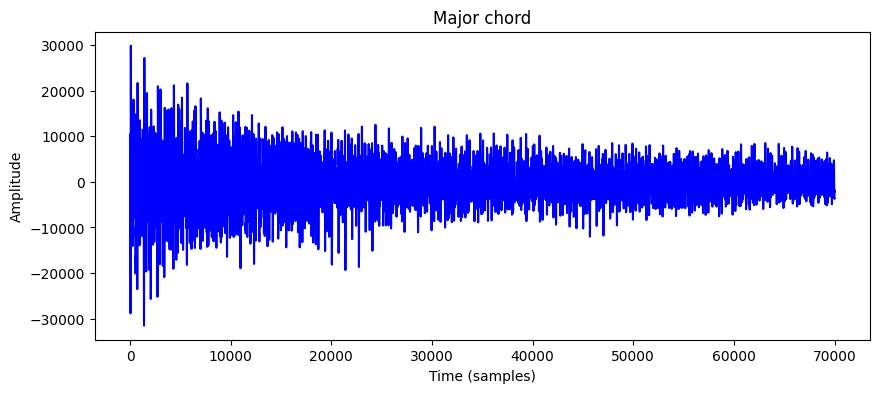

In [ ]:
# open a file
with wave.open(path + 'Major/Major_0.wav', 'r') as audio:
    signal = audio.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    fs = audio.getframerate()
    audio.close()

signal = signal[10000:80000]

# plot the signal
plt.figure(figsize=(10, 4))
plt.plot(signal, color='b')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Major chord')
plt.show()


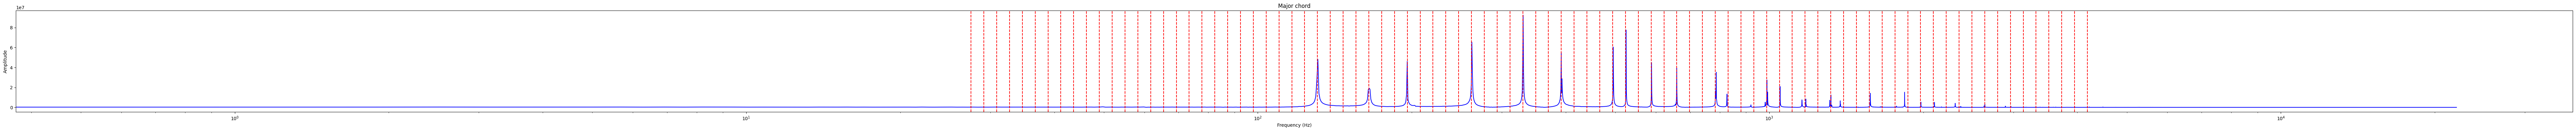

In [ ]:
# piano notes frequencies: from A0 = 27.5 Hz, to C8 = 4186.01 Hz
piano_freq = [27.5 * 2**(i/12) for i in range(88)]

# fft
n = len(signal)
f = np.fft.fftfreq(n, 1/fs)
f = f[:n//2]
signal_fft = np.fft.fft(signal)

# plot the fft in a log scale
plt.figure(figsize=(100, 4))
plt.plot(f, np.abs(signal_fft[:n//2]), color='b')
for freq in piano_freq:
    plt.axvline(x=freq, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Major chord')
plt.show()


In [ ]:
# 